In [1]:
#pycaret version
import pycaret
print('pycaret: %s' % pycaret.__version__)

import rdkit
print('rdkit: %s' % rdkit.__version__)

pycaret: 3.3.2
rdkit: 2023.09.5


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Initial Models Results.csv")
df.head(4)

,Fingerprint Type,Regression Model,R² Score,RMSE,MAE,MSE
0,Morgan,Bayesian Ridge,0.792692,0.109169,0.080328,0.011918
1,Morgan,KNN Regressor,0.621642,0.147483,0.113055,0.021751
2,Morgan,LightGBM,0.785115,0.111146,0.083294,0.012353
3,Morgan,Ridge Regression,0.792956,0.109099,0.079975,0.011903


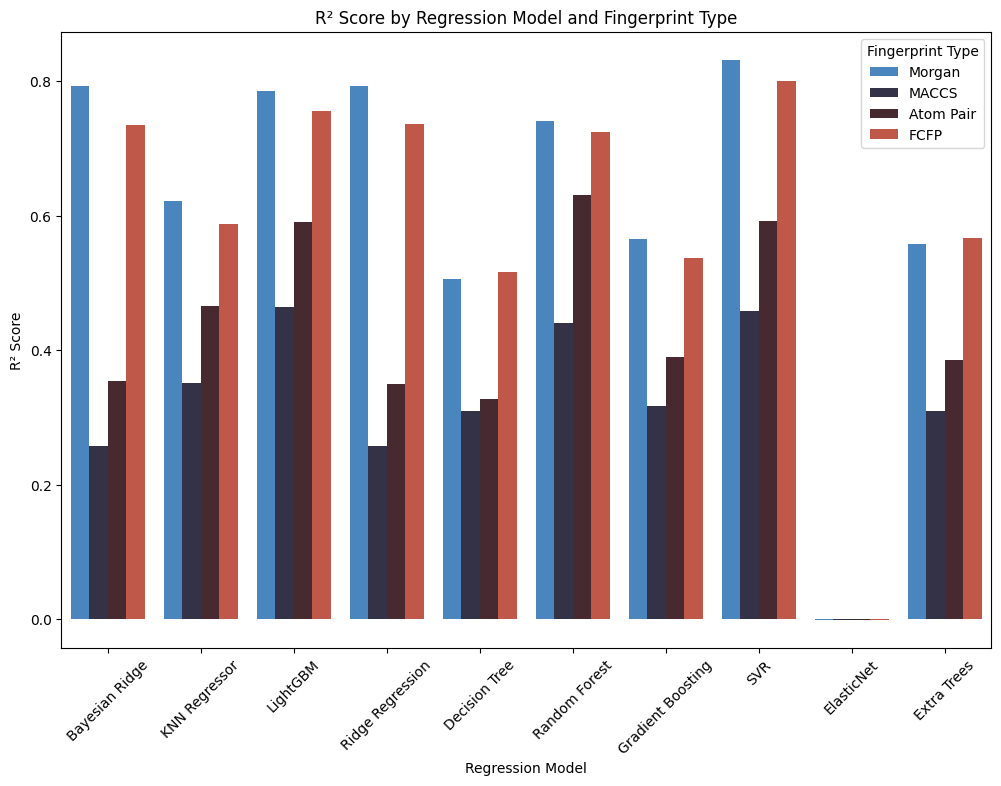

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the color palette
palette = sns.color_palette("icefire", n_colors=df['Fingerprint Type'].nunique())

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Regression Model', y='R² Score', hue='Fingerprint Type', data=df, palette=palette)

# Customize the plot
plt.title('R² Score by Regression Model and Fingerprint Type')
plt.xlabel('Regression Model')
plt.ylabel('R² Score')
plt.legend(title='Fingerprint Type')
plt.xticks(rotation=45)
plt.show()

In [2]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)
curcumin_df['mol'] = curcumin_df['Smiles'].apply(Chem.MolFromSmiles)

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'LUMO_calib_stds',
    'HOMO_calib', 'HOMO_calib_stds','GAP_calc', 'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

CPU times: total: 15.5 s
Wall time: 31.5 s


In [3]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect
import numpy as np

# Functions to generate fingerprints
def generate_morgan_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def generate_maccs166_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

def generate_fcfp_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=True)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Function to add fingerprint to dataframe
def add_fingerprint_to_df(df, fingerprint_func, fp_name):
    df[fp_name] = df['mol'].apply(fingerprint_func)
    return df

# Function to split fingerprints into separate bit columns
def split_fingerprint_bits(df, fp_column, prefix):
    bit_array = np.array([list(fp) for fp in df[fp_column].values])
    bit_columns = pd.DataFrame(bit_array, columns=[f'{prefix}_{i}' for i in range(bit_array.shape[1])])
    df = pd.concat([df.drop(columns=[fp_column]), bit_columns], axis=1)
    return df

# Assuming opv_df is already defined and 'mol' column has been created
# List of fingerprint generation functions and names
fingerprint_functions = [
    (generate_morgan_fingerprint, 'morgan_fp', 'morgan'),
    (generate_maccs166_fingerprint, 'maccs_fp', 'maccs'),
    (generate_atom_pair_fingerprint, 'atom_pair_fp', 'atom_pair'),
    (generate_fcfp_fingerprint, 'fcfp_fp', 'fcfp')
]

# List to store resulting dataframes
resulting_dfs = []

# Generate and store dataframes with fingerprints
for fp_func, fp_name, prefix in fingerprint_functions:
    df_copy = opv_df.copy()
    df_copy = add_fingerprint_to_df(df_copy, fp_func, fp_name)
    df_copy = split_fingerprint_bits(df_copy, fp_name, prefix)
    resulting_dfs.append(df_copy)
    print(f'Finished processing {prefix} fingerprints')

# The resulting_dfs list now contains your four dataframes with split fingerprint columns
opv_df_morgan = resulting_dfs[0]
opv_df_maccs = resulting_dfs[1]
opv_df_atom_pair = resulting_dfs[2]
opv_df_fcfp = resulting_dfs[3]

Finished processing morgan fingerprints
Finished processing maccs fingerprints
Finished processing atom_pair fingerprints
Finished processing fcfp fingerprints
CPU times: total: 4min 33s
Wall time: 4min 42s


In [4]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

models = {
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(),
    'LightGBM': LGBMRegressor(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

for i, df in enumerate([opv_df_morgan, opv_df_maccs, opv_df_atom_pair, opv_df_fcfp]):
    fingerprint_type = ['Morgan', 'MACCS', 'Atom Pair', 'FCFP'][i]
    
    X = df.iloc[:, 3:]  
    y = df["GAP_calib"] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f'Finished processing {fingerprint_type} fingerprints with {model_name} model:')
        
        results.append({
            'Fingerprint Type': fingerprint_type,
            'Regression Model': model_name,
            'R² Score': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse
        })
    print(f'Finished processing {fingerprint_type} fingerprints')

results_df = pd.DataFrame(results)
results_df

Finished processing Morgan fingerprints with Bayesian Ridge model:
Finished processing Morgan fingerprints with KNN Regressor model:


  File "c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 38442, number of used features: 1519
[LightGBM] [Info] Start training from score 2.805288
Finished processing Morgan fingerprints with LightGBM model:
Finished processing Morgan fingerprints with Ridge Regression model:
Finished processing Morgan fingerprints with Decision Tree model:
Finished processing Morgan fingerprints
Finished processing MACCS fingerprints with Bayesian Ridge model:
Finished processing MACCS fingerprints with KNN Regressor model:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

,Fingerprint Type,Regression Model,R² Score,RMSE,MAE,MSE
0,Morgan,Bayesian Ridge,0.845130,0.240031,0.175279,0.057615
1,Morgan,KNN Regressor,0.822717,0.256813,0.177070,0.065953
2,Morgan,LightGBM,0.869593,0.220259,0.160347,0.048514
3,Morgan,Ridge Regression,0.844295,0.240677,0.175110,0.057925
4,Morgan,Decision Tree,0.804685,0.269558,0.173626,0.072661
5,MACCS,Bayesian Ridge,0.589402,0.390834,0.301463,0.152751
6,MACCS,KNN Regressor,0.730760,0.316485,0.232920,0.100163
7,MACCS,LightGBM,0.748884,0.305647,0.231771,0.093420
8,MACCS,Ridge Regression,0.589500,0.390787,0.301380,0.152715
9,MACCS,Decision Tree,0.758939,0.299466,0.218083,0.089680


In [19]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    barmode='group',
    legend_title='Fingerprint Type'
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

In [88]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Find the best combinations for each metric
best_r2 = results_df.loc[results_df['R² Score'].idxmax()]
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
best_mae = results_df.loc[results_df['MAE'].idxmin()]

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    yaxis=dict(range=[0, 1.1]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_r2.add_annotation(
    x=best_r2['Regression Model'],
    y=best_r2['R² Score'],
    text=f"Best: {best_r2['Regression Model']} ({best_r2['Fingerprint Type']})<br>R² Score: {best_r2['R² Score']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-150,
    ay=-50,
    bordercolor="black",
    borderwidth=1
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    yaxis=dict(range=[0, 0.5]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_rmse.add_annotation(
    x=best_rmse['Regression Model'],
    y=best_rmse['RMSE'],
    text=f"Best: {best_rmse['Regression Model']} ({best_rmse['Fingerprint Type']})<br>RMSE: {best_rmse['RMSE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    yaxis=dict(range=[0, 0.4]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_mae.add_annotation(
    x=best_mae['Regression Model'],
    y=best_mae['MAE'],
    text=f"Best: {best_mae['Regression Model']} ({best_mae['Fingerprint Type']})<br>MAE: {best_mae['MAE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Define parameter grids for each model (excluding LGBMRegressor)
param_grids = {
    'Bayesian Ridge': {
        'alpha_1': [1e-6, 1e-4],
        'alpha_2': [1e-6, 1e-4],
        'lambda_1': [1e-6, 1e-4],
        'lambda_2': [1e-6, 1e-4]
    },
    'KNN Regressor': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Fixed parameters for LGBMRegressor
lgbm_params = {
    'learning_rate': 0.23685145356420312,
    'n_estimators': 1000,
    'num_leaves': 51
}

# Initialize models
models = {
    'LightGBM': LGBMRegressor(**lgbm_params),
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor()
}

# Initialize an empty list to store the optimized results
optimized_results = []

# Iterate over the four dataframes
for i, df in enumerate([opv_df_morgan, opv_df_maccs, opv_df_atom_pair, opv_df_fcfp]):
    fingerprint_type = ['Morgan', 'MACCS', 'Atom Pair', 'FCFP'][i]
    
    X = df.iloc[:, 3:]  # Features
    y = df["GAP_calib"]  # Target variable
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Train LightGBM directly with predefined parameters
    model_name = 'LightGBM'
    print(f'Training {model_name} model with {fingerprint_type} fingerprints...')
    
    model = models[model_name]
    model.fit(X_train, y_train)
    
    # Make predictions using the trained model
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Append the results to the optimized_results list
    optimized_results.append({
        'Fingerprint Type': fingerprint_type,
        'Regression Model': model_name,
        'Best Parameters': lgbm_params,
        'R² Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse
    })
    
    print(f'Finished processing {fingerprint_type} fingerprints with optimized {model_name} model')
    
    # Perform grid search for other models
    for model_name, model in models.items():
        if model_name == 'LightGBM':
            continue
        
        print(f'Starting grid search for {model_name} model with {fingerprint_type} fingerprints...')
        
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model after grid search
        best_model = grid_search.best_estimator_
        
        # Make predictions using the optimized model
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Append the results to the optimized_results list
        optimized_results.append({
            'Fingerprint Type': fingerprint_type,
            'Regression Model': model_name,
            'Best Parameters': grid_search.best_params_,
            'R² Score': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse
        })
        
        print(f'Finished processing {fingerprint_type} fingerprints with optimized {model_name} model')

# Convert the results to a DataFrame for analysis
optimized_results_df = pd.DataFrame(optimized_results)
optimized_results_df

Training LightGBM model with Morgan fingerprints...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 38442, number of used features: 1519
[LightGBM] [Info] Start training from score 2.805288
Finished processing Morgan fingerprints with optimized LightGBM model
Starting grid search for Bayesian Ridge model with Morgan fingerprints...
Finished processing Morgan fingerprints with optimized Bayesian Ridge model
Starting grid search for KNN Regressor model with Morgan fingerprints...
Finished processing Morgan fingerprints with optimized KNN Regressor model
Starting grid search for Ridge model with Morgan fingerprints...
Finished processing Morgan fingerprints with optimized Ridge model
Starting grid search for Decision Tree m

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [-0.07219468 -0.07545893         nan -0.07601878 -0.06942001 -0.07136075
 -0.06942001 -0.07252084 -0.07067186 -0.07136595 -0.07067186 -0.07301597]



Finished processing FCFP fingerprints with optimized KNN Regressor model
Starting grid search for Ridge model with FCFP fingerprints...
Finished processing FCFP fingerprints with optimized Ridge model
Starting grid search for Decision Tree model with FCFP fingerprints...
Finished processing FCFP fingerprints with optimized Decision Tree model


,Fingerprint Type,Regression Model,Best Parameters,R² Score,RMSE,MAE,MSE
0,Morgan,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti...",0.939013,0.150627,0.097006,0.022688
1,Morgan,Bayesian Ridge,"{'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_...",0.845130,0.240031,0.175279,0.057615
2,Morgan,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.831352,0.250481,0.174061,0.062741
3,Morgan,Ridge,{'alpha': 1.0},0.844295,0.240677,0.175110,0.057925
4,Morgan,Decision Tree,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.835898,0.247082,0.168776,0.061049
5,MACCS,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti...",0.803317,0.270500,0.199162,0.073170
6,MACCS,Bayesian Ridge,"{'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_...",0.589402,0.390834,0.301463,0.152751
7,MACCS,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.750642,0.304575,0.222676,0.092766
8,MACCS,Ridge,{'alpha': 0.1},0.589487,0.390793,0.301376,0.152719
9,MACCS,Decision Tree,"{'max_depth': 30, 'min_samples_leaf': 2, 'min_...",0.768466,0.293488,0.217238,0.086135


In [22]:
optimized_results_df.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\initcurcumin_optimizedparams.csv", index=False)

In [84]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Order of regression models
model_order = ['Bayesian Ridge', 'KNN Regressor', 'LightGBM', 'Ridge', 'Decision Tree']

# Find the best combinations for each metric
best_r2 = optimized_results_df.loc[optimized_results_df['R² Score'].idxmax()]
best_rmse = optimized_results_df.loc[optimized_results_df['RMSE'].idxmin()]
best_mae = optimized_results_df.loc[optimized_results_df['MAE'].idxmin()]

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    barmode='group',
    yaxis=dict(range=[0, 1.1]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order),
    legend=dict(orientation="h", yanchor="top", y=1.08, xanchor="center", x=0.5),
    width=900, height=600
)

fig_r2.add_annotation(
    x=best_r2['Regression Model'],
    y=best_r2['R² Score'],
    text=f"Best: {best_r2['Regression Model']} ({best_r2['Fingerprint Type']})<br>R² Score: {best_r2['R² Score']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-150,
    ay=-35,
    bordercolor="black",
    borderwidth=1
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    barmode='group',
    yaxis=dict(range=[0, 0.5]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order)  # Set the order of models
)

fig_rmse.add_annotation(
    x=best_rmse['Regression Model'],
    y=best_rmse['RMSE'],
    text=f"Best: {best_rmse['Regression Model']} ({best_rmse['Fingerprint Type']})<br>RMSE: {best_rmse['RMSE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    barmode='group',
    yaxis=dict(range=[0, 0.4]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order)  # Set the order of models
)

fig_mae.add_annotation(
    x=best_mae['Regression Model'],
    y=best_mae['MAE'],
    text=f"Best: {best_mae['Regression Model']} ({best_mae['Fingerprint Type']})<br>MAE: {best_mae['MAE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 1541
[LightGBM] [Info] Start training from score 2.807195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 106
[LightGBM] [Info] Start training from score 2.807195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

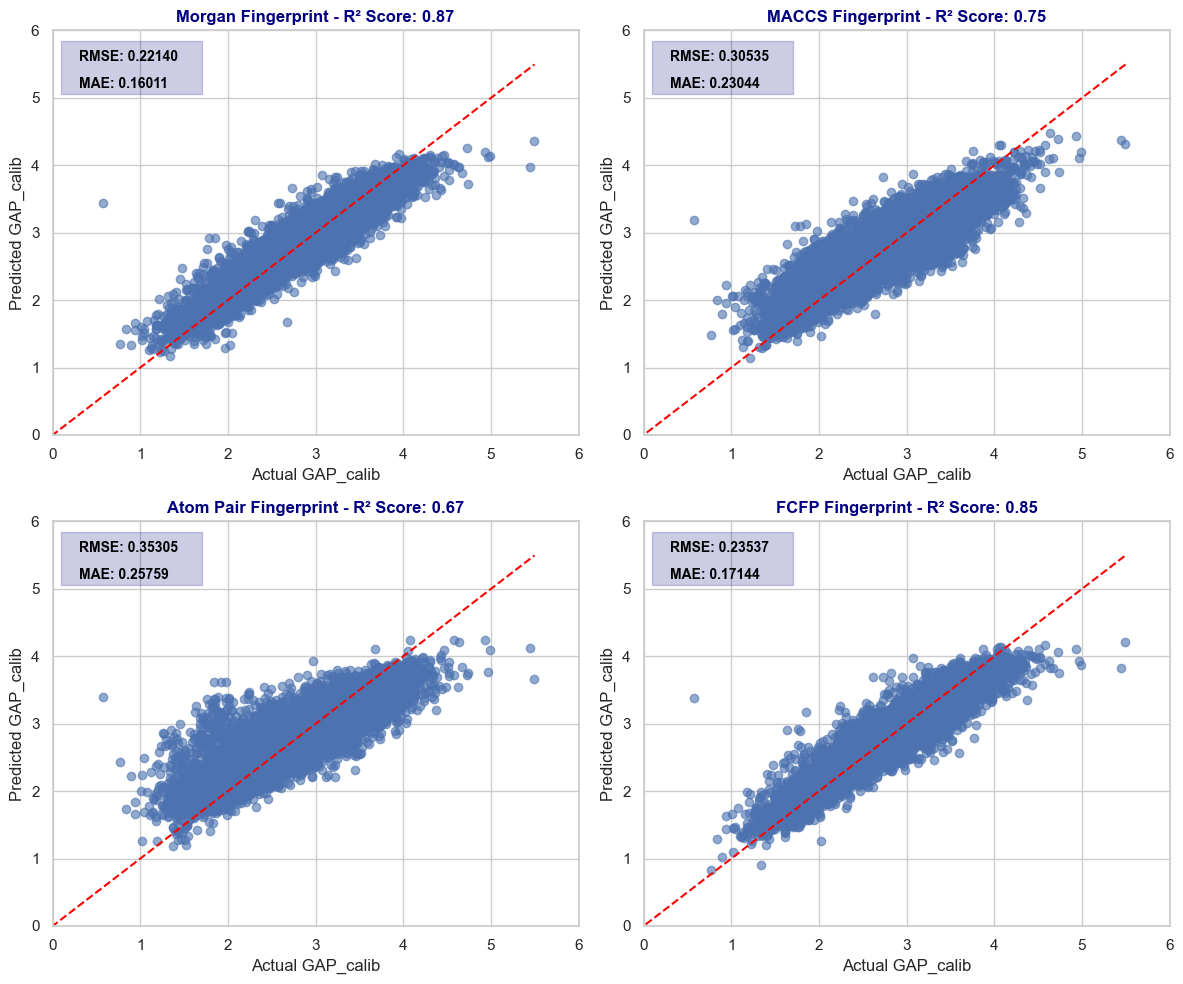

In [69]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming the LightGBM model is already defined and trained
# Define the dataframes and corresponding names
dataframes = {
    'Morgan': opv_df_morgan,
    'MACCS': opv_df_maccs,
    'Atom Pair': opv_df_atom_pair,
    'FCFP': opv_df_fcfp
}

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Iterate over the dataframes and plot actual vs predicted
for idx, (fingerprint_name, df) in enumerate(dataframes.items()):
    X = df.iloc[:, 3:]  # Features
    y = df["GAP_calib"]  # Target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the LightGBM model
    lgbm_model = lgb.LGBMRegressor()
    lgbm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)

    # Calculate R² Score
    r2_score = lgbm_model.score(X_test, y_test)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))

    # Plot the actual vs predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
    axes[idx].set_title(f'{fingerprint_name} Fingerprint - R² Score: {r2_score:.2f}', fontsize=12, weight='bold', color='navy')
    axes[idx].set_xlabel('Actual GAP_calib')
    axes[idx].set_ylabel('Predicted GAP_calib')

    # X and Y limits
    axes[idx].set_xlim(0, 6)
    axes[idx].set_ylim(0, 6)

    # Add RMSE and MAE to the plot
    axes[idx].text(0.3, 5.55, f'RMSE: {rmse:.5f}', fontsize=10, color='black', weight='bold')
    axes[idx].text(0.3, 5.15, f'MAE: {mae:.5f}', fontsize=10, color='black', weight='bold')

    # Draw a square around the text and set the background color to white
    axes[idx].add_patch(plt.Rectangle((0.1, 5.05), 1.6, 0.8, fill='white', color='navy', alpha=0.2))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 1541
[LightGBM] [Info] Start training from score 2.807195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 106
[LightGBM] [Info] Start training from score 2.807195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

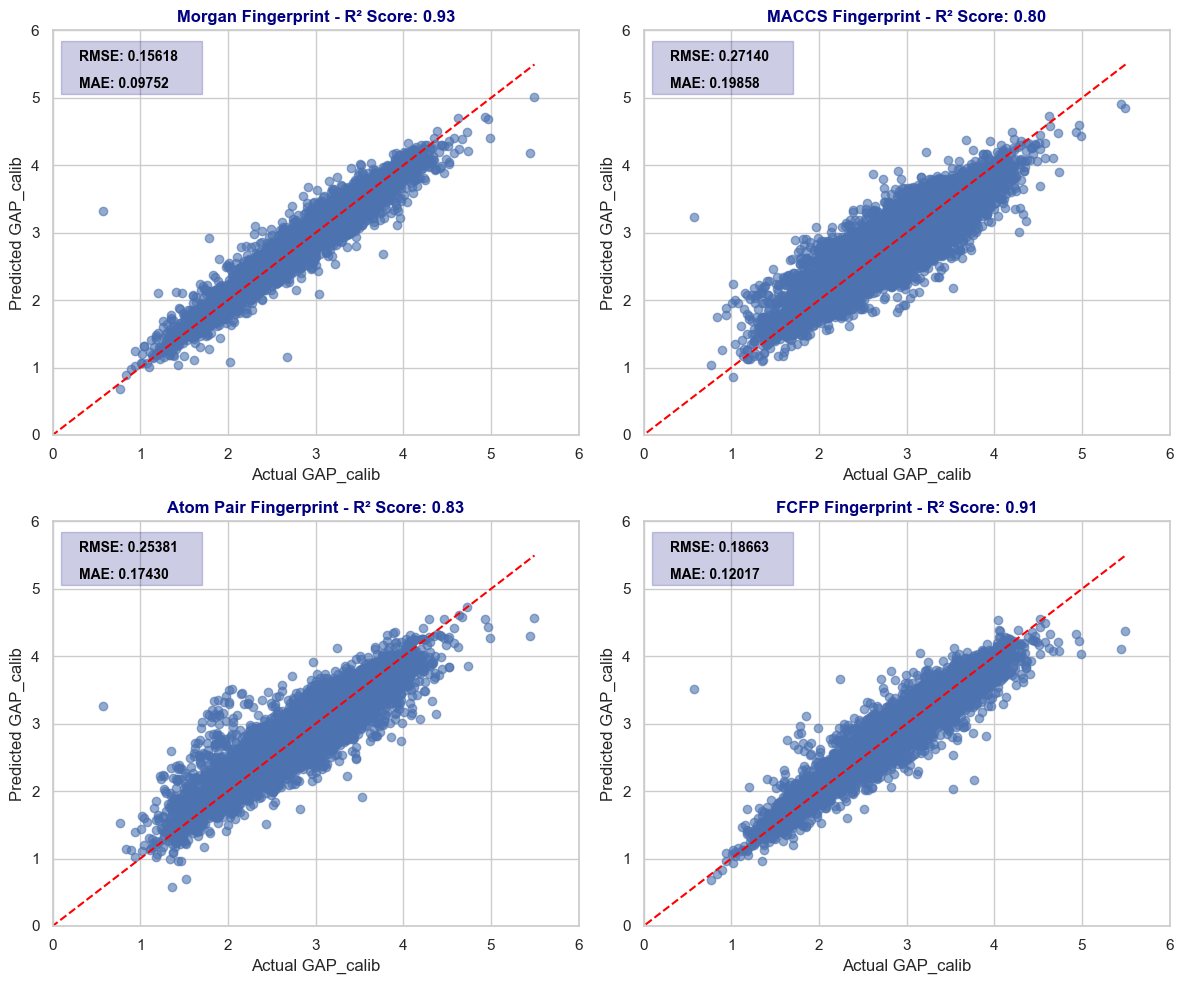

In [70]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Optimized LightGBM parameters
lgbm_params = {
    'learning_rate': 0.23685145356420312,
    'n_estimators': 1000,
    'num_leaves': 51
}

# Assuming the LightGBM model is already defined and trained
# Define the dataframes and corresponding names
dataframes = {
    'Morgan': opv_df_morgan,
    'MACCS': opv_df_maccs,
    'Atom Pair': opv_df_atom_pair,
    'FCFP': opv_df_fcfp
}

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Iterate over the dataframes and plot actual vs predicted
for idx, (fingerprint_name, df) in enumerate(dataframes.items()):
    X = df.iloc[:, 3:]  # Features
    y = df["GAP_calib"]  # Target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the LightGBM model with optimized parameters
    lgbm_model = lgb.LGBMRegressor(**lgbm_params)
    lgbm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)

    # Calculate R² Score
    r2_score = lgbm_model.score(X_test, y_test)

    # Calculate RMSE, R2 Score, and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))

    # Plot the actual vs predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
    axes[idx].set_title(f'{fingerprint_name} Fingerprint - R² Score: {r2_score:.2f}', fontsize=12, weight='bold', color='navy')   
    axes[idx].set_xlabel('Actual GAP_calib')
    axes[idx].set_ylabel('Predicted GAP_calib')

    # X and Y limits
    axes[idx].set_xlim(0, 6)
    axes[idx].set_ylim(0, 6)

    # Add RMSE and MAE to the plot
    axes[idx].text(0.3, 5.55, f'RMSE: {rmse:.5f}', fontsize=10, color='black', weight='bold')
    axes[idx].text(0.3, 5.15, f'MAE: {mae:.5f}', fontsize=10, color='black', weight='bold')

    # Draw a square around the text and set the background color to white
    axes[idx].add_patch(plt.Rectangle((0.1, 5.05), 1.6, 0.8, fill='white', color='navy', alpha=0.2))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()